In [14]:
import os
import time

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import torchvision.utils as tvutils

# import cv2
# import PIL
# import matplotlib.pyplot as plt

from my_utils import data, models
from my_utils.utils import save_model, check_accuracy, trainer
from my_utils.vis import *

%matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:{GPU_nums - 2}" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.10.2
There are 8 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)
CUDA version: 11.3
Using cuda:6 now!


In [16]:
batch_size = 256
fig_resize = 32
# mean, std = torch.tensor(0.2036), torch.tensor(0.4027)  # polygons_unfilled_32_2
mean, std = torch.tensor(0.1094), torch.tensor(0.3660)  # polygons_unfilled_64_3
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((fig_resize, fig_resize)),
    transforms.Normalize(mean, std)
])
loader_kwargs = {
    'batch_size': batch_size,   # default:1
    'shuffle': True,            # default:False
    'num_workers': 4,           # default:0
    'pin_memory': False,        # default:False
    'drop_last': True,          # default:False
    'prefetch_factor': 4,       # default:2
    'persistent_workers': False # default:False
}

In [17]:
# 制作二进制数据集
Dataset_DIR = '/home/wangyh/01-Projects/03-my/Datasets/polygons_unfilled_64_3'

test_data = data.MyDataset(os.path.join(Dataset_DIR, 'test'), transform=T)
test_loader = DataLoader(test_data, **loader_kwargs)

In [19]:
vis_model = models.my_ConvNeXt_vis(kernel_size=7, depths=(1, 1, 1), dims=(4, 8, 16))
vis_model.to(device)

load_path = '/home/wangyh/01-Projects/03-my/newruns/my_convnext/KS_7_LR_1.5e-05_WD_5.0e-04_CT_40/2022_03_17_14_44_31/94_my_convnext_2022_03_17_16_02_54.pt'
checkpoint = torch.load(load_path)
vis_model.load_state_dict(checkpoint["model_paras"])

<All keys matched successfully>

In [20]:
vis_model

my_ConvNeXt_vis(
  (connection_layers): ModuleList(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=16, bias=True)
  )
  (norm_layers): ModuleList(
    (0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(4, 4, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
        (norm): BatchNorm2d(4, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
        (pwconv1): Linear(in_features=4, out_features=8, bias=True)
        (act): ReLU()
        (pwconv2): Linear(in_features=8, out_features=4, bias=True)
      )
    )
    (1): Sequential(
      (0): Block(

In [21]:
img, label = test_data[2000]
img = img[None, :, :, :].to(device, dtype=torch.float32)
# label = label.to(device, dtype=torch.int64)
# vis = img.permute(0, 2, 3, 1)  # (1, C, H, W) -> (1, H, W, C)
scores, mid_outputs = vis_model(img)

In [ ]:
grid_vis(test_loader, 8, )

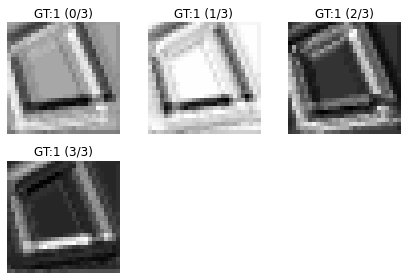

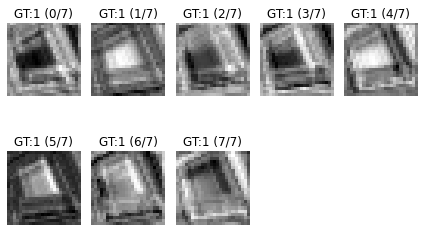

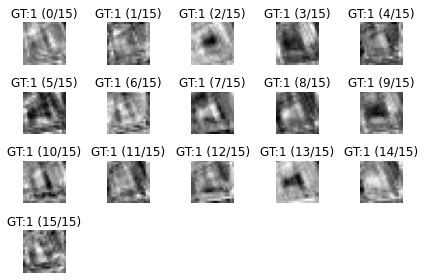

In [22]:
for act in mid_outputs:
    vis_act(act, label)

In [83]:
print('min: ', torch.dist(*mid_outputs[2][0, [9, 29]]))
print('max: ', torch.dist(*mid_outputs[2][0, [4, 13]]))
print('abnormal: ', torch.dist(*mid_outputs[2][0, [4, 8]]))
torch.dist(*mid_outputs[2][0, [24, 31]])

min:  tensor(0.0462)
max:  tensor(0.6510)
abnormal:  tensor(1.1006)


tensor(0.1159)

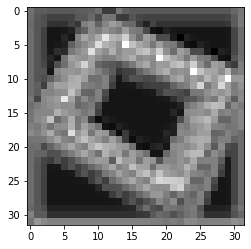

In [15]:
plt.imshow(mid_outputs[2][0][1], "gray")

In [17]:
mid_outputs[2][0][1].max(), mid_outputs[2][0][1].min()

(tensor(0.1592), tensor(-0.1854))

In [30]:
img_tensor = img.squeeze().cpu()
sims = torch.zeros(mid_outputs[2][0].size(0))
for i, act in enumerate(mid_outputs[2][0]):
    sims[i] = (act * img_tensor).sum() / \
              torch.sqrt(torch.sum(act**2) * torch.sum(img_tensor**2))
print(sims)
print(torch.softmax(sims, dim=0))

tensor([ 0.3032,  0.4975,  0.4813,  0.4230,  0.3861, -0.3819, -0.5882,  0.1313,
        -0.5427, -0.0191,  0.5486,  0.3622,  0.1275,  0.5252, -0.3364, -0.1928])
tensor([0.0709, 0.0862, 0.0848, 0.0800, 0.0771, 0.0358, 0.0291, 0.0597, 0.0304,
        0.0514, 0.0907, 0.0753, 0.0595, 0.0886, 0.0374, 0.0432])


In [5]:
from sklearn.decomposition import PCA

In [9]:
test_data = data.MyDataset(os.path.join(Dataset_DIR, 'test'), transform=T)
test_loader = DataLoader(test_data, batch_size=len(test_data))
imgs, labels = next(iter(test_loader))
input_imgs = imgs.reshape(len(test_data), -1)
input_imgs.shape

torch.Size([8000, 1024])

In [10]:
labels.shape

torch.Size([8000])

In [12]:
x2 = PCA(2).fit_transform(input_imgs)
x2.shape

(8000, 2)

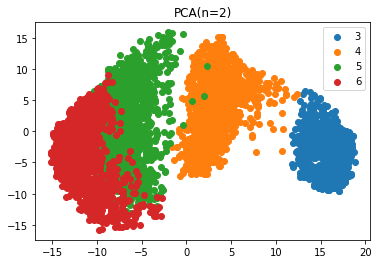

In [19]:
plt.figure()
for i in range(4):
    plt.scatter(x2[labels==i, 0], x2[labels==i, 1], label = f'{i+3}')
plt.legend()
plt.title("PCA(n=2)")
plt.show()

In [16]:
x3 = PCA(3).fit_transform(input_imgs)
x3.shape

(8000, 3)

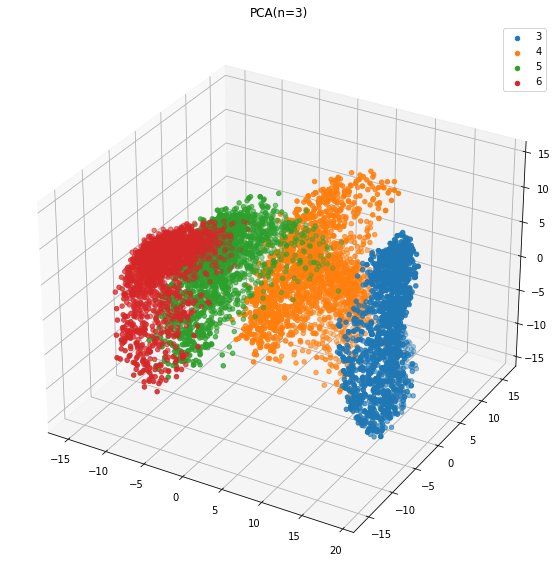

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for i in range(4):
    ax.scatter(x3[labels==i, 0], x3[labels==i, 1], x3[labels==i, 2], label = f'{i+3}')
plt.legend(loc='best')
plt.title("PCA(n=3)")
plt.show()

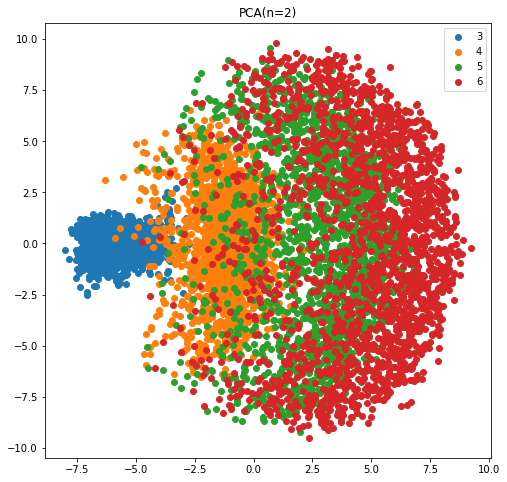

In [13]:
Vis_pca(dim=2,
        dataset_dir='/home/wangyh/01-Projects/03-my/Datasets/polygons_unfilled_64_2',
        dataset_type="val")